In [1]:
from __future__ import print_function
import random as rand
import csv
import operator
import gc
import os
from datetime import datetime
from keras.callbacks import EarlyStopping
from keras.models import load_model
import keras.backend as K
from sklearn.metrics import log_loss
import numpy as np

if K.backend() == 'tensorflow':
    import tensorflow as tf
from setuptools import setup, find_packages

from keras.datasets import mnist
from keras.utils.np_utils import to_categorical
from keras import backend as K
#from devol import DEvol, GenomeHandler
import pandas as pd
from pyspark.sql.types import *
import inspect
from typing import Callable, List
import pandas as pd
from pyspark.sql import DataFrame, Row, column
from pyspark.sql.functions import lit, pandas_udf, PandasUDFType, array
from pyspark.sql.types import FloatType

/home/djg/snap/jupyter/common/lib/python3.7/site-packages/joblib/_multiprocessing_helpers.py:45: UserWarning: [Errno 13] Permission denied.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  0


In [3]:
import pandas as pd
import glob

path = r'./' # use your path
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

In [57]:
#GA avg max and for devol results on mnist


frame = pd.concat(li, axis=0, ignore_index=True)
frame['groups'] = pd.cut(frame.index,10)

frame['cmax'] = frame.groupby(frame['groups'])['Val Accuracy'].cummax()    
results = pd.DataFrame(frame['cmax'])
cmax = results.reset_index(drop = True)
cmax

,cmax
0,0.9853
1,0.9853
2,0.9853
3,0.9853
4,0.9853
...,...
2995,0.9904
2996,0.9904
2997,0.9904
2998,0.9904


In [58]:
#avg avg 
results['cumsum'] = frame.groupby(frame['groups'])['Val Accuracy'].cumsum()
frame['n_evals'] = frame.groupby(frame['groups'])['Val Accuracy'].count()
frame['n_evals'] = 1
results['n_evals'] = frame['n_evals'].groupby(frame['groups']).cumsum()

#foo = frame.groupby(frame['groups']).apply(lambda x: x['cumsum']/ x['n_evals'].astype(float))


results['denom'] = results['n_evals']
results = results.set_index(['n_evals']).reset_index()
#frame['cavg'] = frame['n_evals'].groupby(frame['groups']).cumsum()
#frame['n_evals']


In [59]:

foo = pd.DataFrame(results.groupby(results.index).apply(lambda x: x['cumsum']/ x['denom'].astype(float)))
foo = foo.reset_index(drop = True)
#foo = foo.droplexel(foo.index)foo.reset_index(drop = True)
foo['groups'] = pd.cut(foo.index,300)

foo

,0,groups
0,0.985300,"(-2.999, 9.997]"
1,0.982400,"(-2.999, 9.997]"
2,0.966467,"(-2.999, 9.997]"
3,0.960300,"(-2.999, 9.997]"
4,0.959720,"(-2.999, 9.997]"
...,...,...
2995,0.971839,"(2989.003, 2999.0]"
2996,0.971878,"(2989.003, 2999.0]"
2997,0.971932,"(2989.003, 2999.0]"
2998,0.971971,"(2989.003, 2999.0]"


In [60]:

cavg = foo.groupby(foo['groups']).agg({0:'mean'}).reset_index(drop = True)
cavg = cavg.iloc[:,0]
cavg

0      0.964165
1      0.960041
2      0.962453
3      0.964687
4      0.964769
         ...   
295    0.969717
296    0.970223
297    0.970765
298    0.971282
299    0.971805
Name: 0, Length: 300, dtype: float64

In [61]:

for group in frame.groupby(frame['groups']):
    frame['cmax'] = group[1]['Val Accuracy'].cummax()
    frame['cmean'] = group[1]['Val Accuracy'].expanding().mean()
    #print(group[1]['cmean'])

# DEvol On MNIST Results
### Genome Record

In [62]:
# File location and type
file_location = "./Fri Dec  4 13:21:51 2020.csv"
file_type = "parquet"

# CSV options
infer_schema = "false"
first_row_is_header = "false"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
df = pd.read_csv(file_location, sep = delimiter).head(n=300)

display(df)


,Conv0 active,Conv0 num filters,Conv0 batch normalization,Conv0 activation,Conv0 dropout,Conv0 max pooling,Conv1 active,Conv1 num filters,Conv1 batch normalization,Conv1 activation,...,Conv1 max pooling,Conv2 active,Conv2 num filters,Conv2 batch normalization,Conv2 activation,Conv2 dropout,Conv2 max pooling,Optimizer,Val Loss,Val Accuracy
0,1,8,1,1,5,0,1,8,0,1,...,1,1,32,1,1,5,2,2,0.183955,0.9465
1,1,32,1,1,0,1,1,8,1,1,...,0,1,16,0,0,1,0,3,0.120080,0.9670
2,1,8,0,0,5,0,1,8,0,0,...,1,1,8,1,1,8,1,3,0.153560,0.9715
3,1,64,0,0,3,2,1,32,1,0,...,0,0,16,0,0,9,1,3,0.049458,0.9857
4,1,8,0,0,5,1,1,16,0,0,...,2,1,8,0,0,7,1,0,0.093283,0.9802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,1,8,1,0,8,1,1,64,0,0,...,0,1,32,0,0,5,2,0,0.046555,0.9882
296,1,64,0,0,2,0,1,32,1,1,...,0,1,32,0,0,7,1,0,0.047507,0.9860
297,1,8,1,0,8,0,1,32,0,0,...,0,1,32,0,0,7,2,0,0.043436,0.9870
298,1,8,1,0,8,0,1,16,0,0,...,0,0,8,0,0,7,1,0,0.052383,0.9838


In [63]:
df['cummax'] = df['Val Accuracy'].cummax()
df['cummin'] = df['Val Loss'].cummin()
df

,Conv0 active,Conv0 num filters,Conv0 batch normalization,Conv0 activation,Conv0 dropout,Conv0 max pooling,Conv1 active,Conv1 num filters,Conv1 batch normalization,Conv1 activation,...,Conv2 num filters,Conv2 batch normalization,Conv2 activation,Conv2 dropout,Conv2 max pooling,Optimizer,Val Loss,Val Accuracy,cummax,cummin
0,1,8,1,1,5,0,1,8,0,1,...,32,1,1,5,2,2,0.183955,0.9465,0.9465,0.183955
1,1,32,1,1,0,1,1,8,1,1,...,16,0,0,1,0,3,0.120080,0.9670,0.9670,0.120080
2,1,8,0,0,5,0,1,8,0,0,...,8,1,1,8,1,3,0.153560,0.9715,0.9715,0.120080
3,1,64,0,0,3,2,1,32,1,0,...,16,0,0,9,1,3,0.049458,0.9857,0.9857,0.049458
4,1,8,0,0,5,1,1,16,0,0,...,8,0,0,7,1,0,0.093283,0.9802,0.9857,0.049458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,1,8,1,0,8,1,1,64,0,0,...,32,0,0,5,2,0,0.046555,0.9882,0.9907,0.033976
296,1,64,0,0,2,0,1,32,1,1,...,32,0,0,7,1,0,0.047507,0.9860,0.9907,0.033976
297,1,8,1,0,8,0,1,32,0,0,...,32,0,0,7,2,0,0.043436,0.9870,0.9907,0.033976
298,1,8,1,0,8,0,1,16,0,0,...,8,0,0,7,1,0,0.052383,0.9838,0.9907,0.033976


(0.95, 1.0)

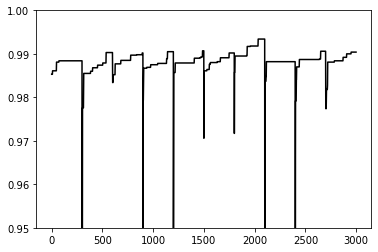

In [67]:
import matplotlib.pyplot as plt
fig = plt.figure() 
ax = fig.add_subplot(1, 1, 1) 
ax.plot(cmax.index, cmax, color ='k',) 

ax.set_ylim(0.95,1)


Text(0.5, 1.0, 'DEvol. Population size: 20 max_fit = 0.9907')

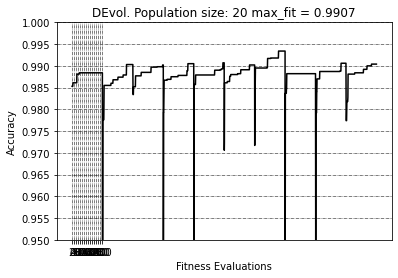

In [64]:

#fig, ax = plt.plot(df['cummax'])
ax.set_ylim(0.95,1)
ax.set_yticks(list(np.arange(0.95,1,0.005)))
ax.set_ylabel('Accuracy')

ax.set_xticks(list(np.arange(0,301,20)))
ax.set_xlabel('Fitness Evaluations')

ax.grid(color='k', linestyle='-.', linewidth=0.5)
ax.set_title('DEvol. Population size: 20 max_fit = 0.9907')


In [65]:
list(np.arange(0.95,1,0.005))

[0.95, 0.955, 0.96, 0.965, 0.97, 0.975, 0.98, 0.985, 0.99, 0.995, 1.0]